In [1]:
import pandas as pd
import numpy as np
import os
import time
import json
import pickle

# Colab
from google.colab import drive
drive.mount('/content/gdrive')

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import cv2

import sklearn
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

Mounted at /content/gdrive


In [ ]:
def plotROCCurve(fpr, tpr, auc, color, label, title):
    plt.figure(figsize=(14,8))
    ax = plt.gca()
    ax.set_facecolor((1.0, 1.0, 1.0))
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth('2')  
    ax.grid(b=True, which='major', color='grey', linestyle='-', alpha=0.3)
    plt.plot(fpr,tpr, lw=2, label= label+' (area = {:.3f})'.format(auc),color = color)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    legend = plt.legend(loc="best", edgecolor="grey")
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((1, 1, 1, 0.7))
    plt.show()

# Augmented Train, unbalanced Validation & Test

In [2]:
features_train_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/complete_features_train.npy'
labels_train_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/complete_labels_train.npy'

train_features = np.load(features_train_path)
train_labels = np.load(labels_train_path)

In [3]:
features_test_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/complete_features_test.npy'
labels_test_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/complete_labels_test.npy'

test_features = np.load(features_test_path)
test_labels = np.load(labels_test_path)

In [4]:
train_labels = label_binarize(train_labels, classes=['Negative', 'Positive'])
test_labels = label_binarize(test_labels, classes=['Negative', 'Positive'])

In [5]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(12145, 3, 15, 259)
(12145, 1)
(2424, 3, 15, 259)
(2424, 1)


In [6]:
X_train = train_features
y_train = train_labels
X_val, X_test, y_val, y_test = train_test_split(test_features, test_labels, test_size=0.5, stratify=test_labels, random_state=1)
X_train = X_train.reshape(X_train.shape[0], -1, 15, 3)
X_val = X_val.reshape(X_val.shape[0], -1, 15, 3)
X_test = X_test.reshape(X_test.shape[0], -1, 15, 3)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(12145, 259, 15, 3)
(12145, 1)
(1212, 259, 15, 3)
(1212, 1)
(1212, 259, 15, 3)
(1212, 1)


In [ ]:
inputs = keras.Input((259,15,3))

x = inputs
x = keras.layers.Conv2D(filters=64, kernel_size=(3,3), input_shape=(259,15,3), activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=3e-4, l2=3e-3),
                       bias_regularizer=keras.regularizers.l2(3e-3), activity_regularizer=keras.regularizers.l2(3e-4))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-3, l2=1e-2),
                       bias_regularizer=keras.regularizers.l2(1e-2), activity_regularizer=keras.regularizers.l2(1e-3))(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
net = keras.Model(inputs, outputs)

In [ ]:
net.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 259, 15, 3)]      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 257, 13, 64)       1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 6, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 127, 5, 32)        8224      
                                                                 
 batch_normalization_4 (Batc  (None, 127, 5, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_4 (Flatten)         (None, 20320)             0   

In [ ]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC')
]

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
net.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS)

In [8]:
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/Model/best_model.hdf5'

In [ ]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_recall',
    mode='max',
    save_best_only=True)

In [ ]:
history = net.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_val, y_val),
                  callbacks=[model_checkpoint_callback])

Epoch 1/50
95/95 [==============================] - 3s 18ms/step - loss: 14.7917 - accuracy: 0.8022 - precision: 0.6944 - recall: 0.3269 - AUC: 0.7622 - val_loss: 10.3346 - val_accuracy: 0.9332 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.4839
Epoch 2/50
95/95 [==============================] - 1s 12ms/step - loss: 7.6167 - accuracy: 0.8844 - precision: 0.8643 - recall: 0.6197 - AUC: 0.8857 - val_loss: 5.4466 - val_accuracy: 0.9257 - val_precision: 0.0333 - val_recall: 0.0161 - val_AUC: 0.4765
Epoch 3/50
95/95 [==============================] - 1s 12ms/step - loss: 4.4962 - accuracy: 0.9103 - precision: 0.8943 - recall: 0.7136 - AUC: 0.9131 - val_loss: 3.8029 - val_accuracy: 0.9043 - val_precision: 0.0645 - val_recall: 0.0645 - val_AUC: 0.4747
Epoch 4/50
95/95 [==============================] - 1s 10ms/step - loss: 3.3315 - accuracy: 0.9247 - precision: 0.9207 - recall: 0.7541 - AUC: 0.9223 - val_loss: 3.0110 - val_accuracy: 0.9026 - val_precision: 0.0625 - val_rec

In [9]:
# Load best model
model = load_model(checkpoint_filepath)

In [14]:
# Scores
val_score = model.evaluate(X_val, y_val)
test_score = model.evaluate(X_test, y_test)

38/38 [==============================] - 1s 38ms/step - loss: 3.8058 - accuracy: 0.8944 - precision: 0.0411 - recall: 0.0492 - AUC: 0.5199


In [16]:
print('Validation: ', val_score)
print('Test: ', test_score)

Validation:  [3.802877902984619, 0.9042904376983643, 0.06451612710952759, 0.06451612710952759, 0.4746493697166443]
Test:  [3.805828094482422, 0.8943894505500793, 0.04109589010477066, 0.04918032884597778, 0.5199042558670044]


In [ ]:
# Performance on validation
COVIDpred_val = model.predict(X_val)
COVIDpred_val = np.where(COVIDpred_val >= 0.5, 1, 0)

38/38 [==============================] - 8s 3ms/step


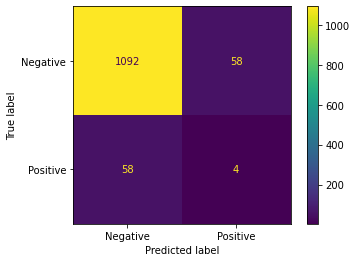

In [ ]:
cm = confusion_matrix(y_val, COVIDpred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=('Negative', 'Positive'))
disp.plot()

In [ ]:
# Performance on test
COVIDpred_test = model.predict(X_test)
COVIDpred_test = np.where(COVIDpred_test >= 0.5, 1, 0)

38/38 [==============================] - 0s 2ms/step


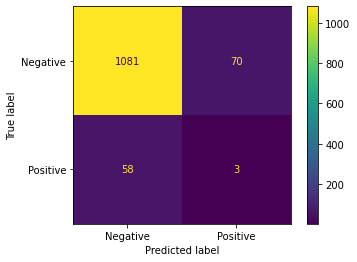

In [ ]:
cm = confusion_matrix(y_test, COVIDpred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=('Negative', 'Positive'))
disp.plot()

# Augmentation on full dataset

In [17]:
feat_path_full = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/complete_features.npy'
labels_path_full = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/complete_labels.npy'

features = np.load(feat_path_full)
labels = np.load(labels_path_full)

In [18]:
labels = label_binarize(labels, classes=['Negative', 'Positive'])

In [19]:
print(features.shape)
print(labels.shape)

(15184, 3, 15, 259)
(15184, 1)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=1)
X_train = X_train.reshape(X_train.shape[0], -1, 15, 3)
X_val = X_val.reshape(X_val.shape[0], -1, 15, 3)
X_test = X_test.reshape(X_test.shape[0], -1, 15, 3)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(12147, 259, 15, 3)
(12147, 1)
(1518, 259, 15, 3)
(1518, 1)
(1519, 259, 15, 3)
(1519, 1)


In [ ]:
inputs = keras.Input((259,15,3))

x = inputs
x = keras.layers.Conv2D(filters=64, kernel_size=(3,3), input_shape=(259,15,3), activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=3e-4, l2=3e-3),
                       bias_regularizer=keras.regularizers.l2(3e-3), activity_regularizer=keras.regularizers.l2(3e-4))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-3, l2=1e-2),
                       bias_regularizer=keras.regularizers.l2(1e-2), activity_regularizer=keras.regularizers.l2(1e-3))(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
net = keras.Model(inputs, outputs)

In [ ]:
net.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 259, 15, 3)]      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 257, 13, 64)       1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 6, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 127, 5, 32)        8224      
                                                                 
 batch_normalization_5 (Batc  (None, 127, 5, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_5 (Flatten)         (None, 20320)             0   

In [21]:
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/Model/best_model.hdf5'

In [ ]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC')
]

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
net.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS)

In [ ]:
history = net.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_val, y_val),
                  callbacks=[model_checkpoint_callback])

Epoch 1/50
95/95 [==============================] - 3s 18ms/step - loss: 14.5864 - accuracy: 0.8166 - precision: 0.7412 - recall: 0.3729 - AUC: 0.7835 - val_loss: 10.2204 - val_accuracy: 0.8775 - val_precision: 0.9174 - val_recall: 0.5435 - val_AUC: 0.8672
Epoch 2/50
95/95 [==============================] - 1s 12ms/step - loss: 7.4338 - accuracy: 0.8955 - precision: 0.8706 - recall: 0.6679 - AUC: 0.8917 - val_loss: 5.3791 - val_accuracy: 0.8874 - val_precision: 0.7444 - val_recall: 0.8152 - val_AUC: 0.8904
Epoch 3/50
95/95 [==============================] - 1s 12ms/step - loss: 4.3623 - accuracy: 0.9197 - precision: 0.9219 - recall: 0.7305 - AUC: 0.9098 - val_loss: 3.6772 - val_accuracy: 0.9065 - val_precision: 0.8054 - val_recall: 0.8098 - val_AUC: 0.8996
Epoch 4/50
95/95 [==============================] - 1s 12ms/step - loss: 3.2099 - accuracy: 0.9244 - precision: 0.9310 - recall: 0.7430 - AUC: 0.9216 - val_loss: 2.8365 - val_accuracy: 0.9282 - val_precision: 0.9137 - val_recall: 0.7

In [22]:
# Load best model
model = load_model(checkpoint_filepath)

In [23]:
# Scores
val_score = model.evaluate(X_val, y_val)
test_score = model.evaluate(X_test, y_test)

48/48 [==============================] - 2s 37ms/step - loss: 0.4067 - accuracy: 0.9421 - precision: 0.9459 - recall: 0.8071 - AUC: 0.9218


In [24]:
print('Validation: ', val_score)
print('Test: ', test_score)

Validation:  [0.4187593460083008, 0.9420289993286133, 0.9666666388511658, 0.7880434989929199, 0.9116363525390625]
Test:  [0.40674078464508057, 0.9420671463012695, 0.9458598494529724, 0.8070651888847351, 0.921777606010437]


In [ ]:
# Performance on validation
COVIDpred_val = model.predict(X_val)
COVIDpred_val = np.where(COVIDpred_val >= 0.5, 1, 0)

48/48 [==============================] - 0s 3ms/step


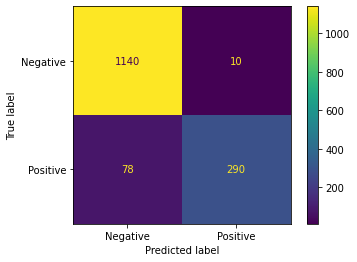

In [ ]:
cm = confusion_matrix(y_val, COVIDpred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=('Negative', 'Positive'))
disp.plot()

In [ ]:
# Performance on test
COVIDpred_test = model.predict(X_test)
COVIDpred_test = np.where(COVIDpred_test >= 0.5, 1, 0)

48/48 [==============================] - 0s 2ms/step


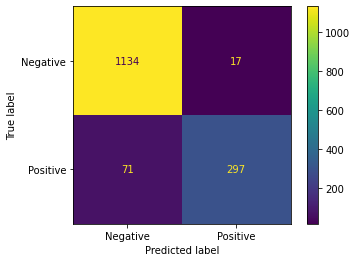

In [ ]:
cm = confusion_matrix(y_test, COVIDpred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=('Negative', 'Positive'))
disp.plot()

## Cross-Validation on full-augmented dataset

In [ ]:
feat_path_full = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/complete_features.npy'
labels_path_full = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/complete_labels.npy'

features = np.load(feat_path_full)
labels = np.load(labels_path_full)

labels = label_binarize(labels, classes=['Negative', 'Positive'])

print(features.shape)
print(labels.shape)

(15184, 3, 15, 259)
(15184, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=1)
X_train = X_train.reshape(X_train.shape[0], -1, 15, 3)
X_test = X_test.reshape(X_test.shape[0], -1, 15, 3)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12147, 259, 15, 3)
(12147, 1)
(3037, 259, 15, 3)
(3037, 1)


In [ ]:
## Start 10-fold cross-validation

num_folds = 10
fold_no = 1

loss_per_fold = []
acc_per_fold = []
precision_per_fold = []
recall_per_fold = []
auc_per_fold = []
histories = []

In [ ]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC')
]

kfold = KFold(n_splits = num_folds, shuffle = True, random_state=123)

In [ ]:
for train, test in kfold.split(X_train, y_train):
    ### Hyperparameter definition
    epochs = 30
    batch_size = 128
    learning_rate = 0.0001
    filepath = "/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/CrossValidation/model_best_weights_" + str(fold_no) + ".hdf5"    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    ###### Model architecture
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    inputs = keras.Input((259,15,3))
    x = inputs
    x = keras.layers.Conv2D(filters=64, kernel_size=(3,3), input_shape=(259,15,3), activation='relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = keras.layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=3e-4, l2=3e-3), 
                           bias_regularizer=keras.regularizers.l2(3e-3), activity_regularizer=keras.regularizers.l2(3e-4))(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-3, l2=1e-2),
                           bias_regularizer=keras.regularizers.l2(1e-2), activity_regularizer=keras.regularizers.l2(1e-3))(x)
    x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    net = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    net.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS)

    start = time.time()
    history = net.fit(X_train[train], y_train[train], batch_size=batch_size, epochs=epochs, verbose=1, 
                      validation_data=(X_train[test], y_train[test]), callbacks=[checkpoint])
    end = time.time()
    print("Training time : ", (end-start))

    ### Calcolo risultati
    histories.append(history)

    scores = net.evaluate(X_train[test], y_train[test], verbose=0)
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1])
    precision_per_fold.append(scores[2])
    recall_per_fold.append(scores[3])
    auc_per_fold.append(scores[4])
    
    ### Mostro i risultati
    model = load_model('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/CrossValidation/model_best_weights_' + str(fold_no) + '.hdf5')
    val_score = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("Validation results for the fold " + str(fold_no) + ":")
    print("Accuracy: ", val_score[1])
    print("Precision: ", val_score[2])
    print("Recall: ", val_score[3])
    print("ROC AUC: ", val_score[4])

    test_score = model.evaluate(X_test, y_test,verbose=0)
    print("Test results for the fold " + str(fold_no) + ":")
    print("Accuracy : ", test_score[1])
    print("Precision : ", test_score[2])
    print("Recall : ", test_score[3])
    print("ROC AUC : ", test_score[4])
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
86/86 [==============================] - ETA: 0s - loss: 15.0846 - accuracy: 0.7965 - precision: 0.6712 - recall: 0.3162 - AUC: 0.7365
Epoch 1: val_accuracy improved from -inf to 0.86667, saving model to /content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/CrossValidation/model_best_weights_1.hdf5
86/86 [==============================] - 6s 19ms/step - loss: 15.0846 - accuracy: 0.7965 - precision: 0.6712 - recall: 0.3162 - AUC: 0.7365 - val_loss: 10.9055 - val_accuracy: 0.8667 - val_precision: 0.8128 - val_recall: 0.5709 - val_AUC: 0.8684
Epoch 2/30
81/86 [===========================>..] - ETA: 0s - loss: 8.2578 - accuracy: 0.8632 - precision: 0.8402 - recall: 0.5438 - AUC: 0.8650
Epoch 2: val_accuracy improved from 0.86667 to 0.88889, saving model to /content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBef

In [ ]:
# Saving metrics
with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/CrossValidation/loss_per_fold.json', 'w') as f:
    json.dump(loss_per_fold, f)

with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/CrossValidation/accuracy_per_fold.json', 'w') as f:
    json.dump(acc_per_fold, f)

with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/CrossValidation/precision_per_fold.json', 'w') as f:
    json.dump(precision_per_fold, f)

with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/CrossValidation/recall_per_fold.json', 'w') as f:
    json.dump(recall_per_fold, f)

with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/CrossValidation/auc_per_fold.json', 'w') as f:
    json.dump(auc_per_fold, f)

In [ ]:
# Saving histories
with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/CrossValidation/trainHistory', 'wb') as file_pi:
      pickle.dump(histories, file_pi)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/CrossValidation/trainHistory', 'rb') as hist_file:
    histories = pickle.load(hist_file)

In [ ]:
# Validation scores
print("Accuracy per fold : ", acc_per_fold)
print("Loss per fold : ", loss_per_fold)
print("Precision per fold : ", precision_per_fold)
print("Recall per fold : ", recall_per_fold)
print("ROC AUC per fold : ", auc_per_fold)

print("-------------------------------------------------------------------------")

print("Accuracy : ", np.mean(acc_per_fold), " +/- ", np.std(acc_per_fold))
print("Loss : ", np.mean(loss_per_fold), " +/- ", np.std(loss_per_fold))
print("Precision : ", np.mean(precision_per_fold), " +/- ", np.std(precision_per_fold))
print("Recall : ", np.mean(recall_per_fold), " +/- ", np.std(recall_per_fold))
print("ROC AUC : ", np.mean(auc_per_fold), " +/- ", np.std(auc_per_fold))

Accuracy per fold :  [0.9448559880256653, 0.9283950328826904, 0.9358024597167969, 0.9308642148971558, 0.9382715821266174, 0.9259259104728699, 0.9333333373069763, 0.9341021180152893, 0.9439868330955505, 0.9439868330955505]
Loss per fold :  [0.3532455563545227, 0.45698463916778564, 0.4012641906738281, 0.4192248582839966, 0.397664874792099, 0.45018938183784485, 0.42470890283584595, 0.4144098460674286, 0.3845909535884857, 0.39343157410621643]
Precision per fold :  [0.9404761791229248, 0.9594594836235046, 0.9186992049217224, 0.9613733887672424, 0.9440000057220459, 0.9406779408454895, 0.9097744226455688, 0.9353612065315247, 0.9907833933830261, 0.9829787015914917]
Recall per fold :  [0.8200691938400269, 0.7319587469100952, 0.7957746386528015, 0.7491638660430908, 0.7946127653121948, 0.744966447353363, 0.8093645572662354, 0.7961165308952332, 0.7651245594024658, 0.7830508351325989]
ROC AUC per fold :  [0.9325035810470581, 0.8901106715202332, 0.9188117384910583, 0.9025517702102661, 0.910871565341

Text(0, 0.5, 'Recall')

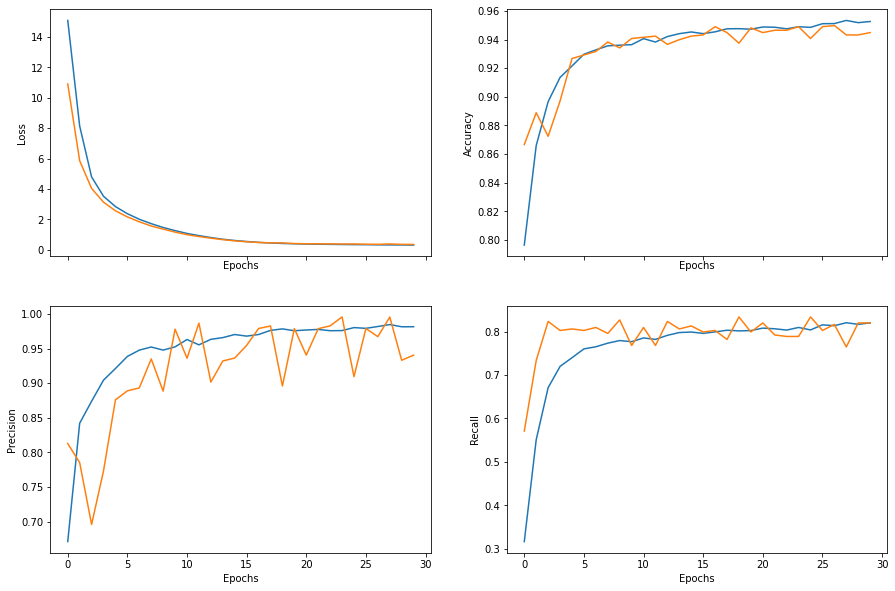

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15,10), sharex=True)
ax[0, 0].plot(histories[0].history['loss'])
ax[0, 0].plot(histories[0].history['val_loss'])
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
###########################################
ax[0, 1].plot(histories[0].history['accuracy'])
ax[0, 1].plot(histories[0].history['val_accuracy'])
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('Accuracy')
###########################################
ax[1, 0].plot(histories[0].history['precision'])
ax[1, 0].plot(histories[0].history['val_precision'])
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('Precision')
###########################################
ax[1, 1].plot(histories[0].history['recall'])
ax[1, 1].plot(histories[0].history['val_recall'])
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('Recall')

[0.37368470430374146, 0.9460171461105347, 0.9554139971733093, 0.8152173757553101, 0.9193282127380371]
48/48 [==============================] - 2s 31ms/step


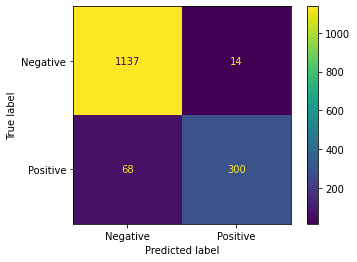

In [25]:
# Load best model
model_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/CrossValidation/model_best_weights_1.hdf5'
model_1 = load_model(model_path)

scores = model_1.evaluate(X_test, y_test, verbose=0)
print(scores)

# Performance on test
COVIDpred = model_1.predict(X_test)
COVIDpred = np.where(COVIDpred >= 0.5, 1, 0)

cm = confusion_matrix(y_test, COVIDpred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=('Negative', 'Positive'))
disp.plot()